In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [19]:
df = pd.read_csv('C:/Users/prisc/OneDrive/Escritorio/5to semestre/Minería/Project-No.-1_N-grams/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


# División train/test

In [21]:
train_df, test_df = train_test_split(df, test_size=0.5, random_state=42, stratify=df['sentiment'])

print("Tamaño train:", len(train_df))
print("Tamaño test:", len(test_df))


Tamaño train: 25000
Tamaño test: 25000


# Pre-Procesamiento

In [25]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prisc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\prisc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [22]:
# Descargar recursos de NLTK (una sola vez)
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\prisc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prisc\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [23]:
STOPWORDS = set(stopwords.words("english"))
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

In [26]:
def preprocess_text(text, remove_stopwords=False):
    # Minúsculas
    text = text.lower()
    # Eliminar HTML
    text = re.sub(r"<.*?>", " ", text)
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar tokens que no son alfanuméricos
    tokens = [t for t in tokens if any(c.isalnum() for c in t)]
    # Eliminar stopwords si se quiere
    if remove_stopwords:
        tokens = [t for t in tokens if t not in STOPWORDS]
    return " ".join(tokens)

# Aplicamos a train y test
train_df["clean_review"] = train_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))
test_df["clean_review"] = test_df["review"].apply(lambda x: preprocess_text(x, remove_stopwords=False))

train_df.head()

,review,sentiment,clean_review
3055,Trio's vignettes were insightful and quite enj...,positive,trio 's vignettes were insightful and quite en...
47326,I had never heard of this one before the owner...,negative,i had never heard of this one before the owner...
48869,This is an excellent but hard to find trippy W...,positive,this is an excellent but hard to find trippy w...
48623,"I am a huge fan of big, loud, trashy, complete...",positive,i am a huge fan of big loud trashy completely ...
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive,easily lucio fulci 's most respected film do n...


# Extracción de características

In [ ]:
# Definir el vectorizador con unigramas, bigramas y trigramas
vectorizer = CountVectorizer(ngram_range=(1,3), max_features=50000)  
# max_features: limita vocabulario para no explotar la RAM

#  Ajustar al train y transformar
X_train = vectorizer.fit_transform(train_df["clean_review"])
X_test = vectorizer.transform(test_df["clean_review"])

y_train = train_df["sentiment"]
y_test = test_df["sentiment"]

print("Shape X_train:", X_train.shape)
print("Shape X_test:", X_test.shape)

Shape X_train: (25000, 50000)
Shape X_test: (25000, 50000)


# Entrenamiento de Modelo

## Regresión Logística

In [ ]:
logreg = LogisticRegression(max_iter=1000, solver="saga")
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

c:\Users\prisc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


🔹 Logistic Regression
Accuracy: 0.90112
              precision    recall  f1-score   support

    negative       0.91      0.90      0.90     12500
    positive       0.90      0.91      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



## Naive Bayes

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)
print("Naive Bayes")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

🔹 Naive Bayes
Accuracy: 0.86696
              precision    recall  f1-score   support

    negative       0.87      0.87      0.87     12500
    positive       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



## SVM

In [ ]:
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
print("SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

c:\Users\prisc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


🔹 SVM
Accuracy: 0.88444
              precision    recall  f1-score   support

    negative       0.89      0.88      0.88     12500
    positive       0.88      0.89      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



# Evaluación

In [35]:
def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=["positive", "negative"])
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["positive", "negative"],
                yticklabels=["positive", "negative"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

## Regresión Logística

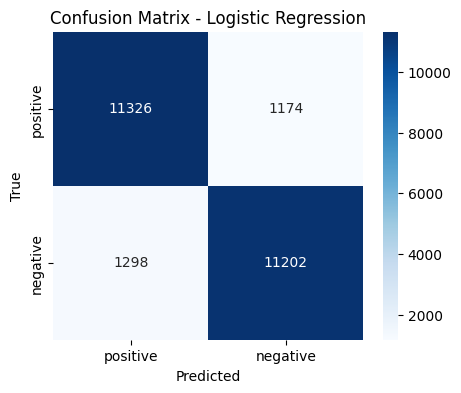

In [36]:
plot_confusion(y_test, y_pred_logreg, "Confusion Matrix - Logistic Regression")

## Naive Bayes

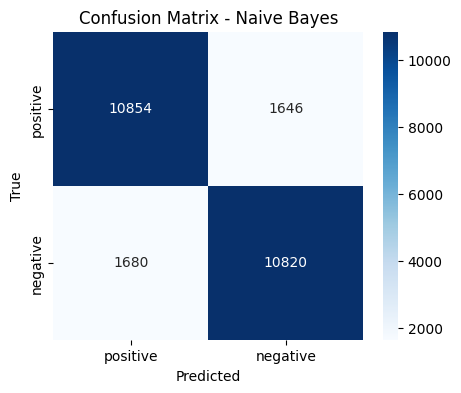

In [37]:
plot_confusion(y_test, y_pred_nb, "Confusion Matrix - Naive Bayes")


## SVM

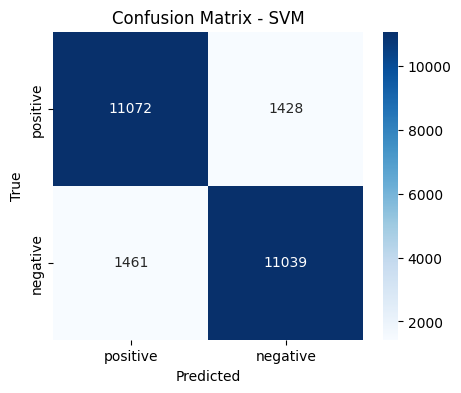

In [38]:
plot_confusion(y_test, y_pred_svm, "Confusion Matrix - SVM")


Modelo: LogisticRegression
Accuracy: 0.9011
Macro - Precision: 0.9012  Recall: 0.9011  F1: 0.9011
Weighted - Precision: 0.9012  Recall: 0.9011  F1: 0.9011

Per-class (positive / negative):
 Precision: 0.8972 / 0.9051
 Recall:    0.9061 / 0.8962
 F1-score:  0.9016 / 0.9006

Classification report:

              precision    recall  f1-score   support

    positive       0.90      0.91      0.90     12500
    negative       0.91      0.90      0.90     12500

    accuracy                           0.90     25000
   macro avg       0.90      0.90      0.90     25000
weighted avg       0.90      0.90      0.90     25000



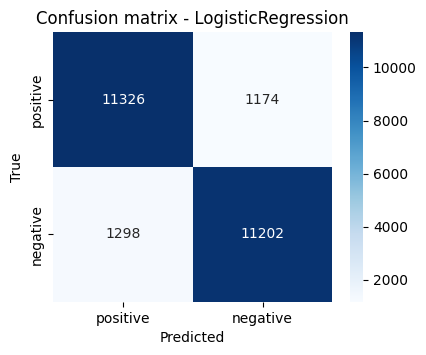


Modelo: MultinomialNB
Accuracy: 0.8670
Macro - Precision: 0.8670  Recall: 0.8670  F1: 0.8670
Weighted - Precision: 0.8670  Recall: 0.8670  F1: 0.8670

Per-class (positive / negative):
 Precision: 0.8660 / 0.8680
 Recall:    0.8683 / 0.8656
 F1-score:  0.8671 / 0.8668

Classification report:

              precision    recall  f1-score   support

    positive       0.87      0.87      0.87     12500
    negative       0.87      0.87      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



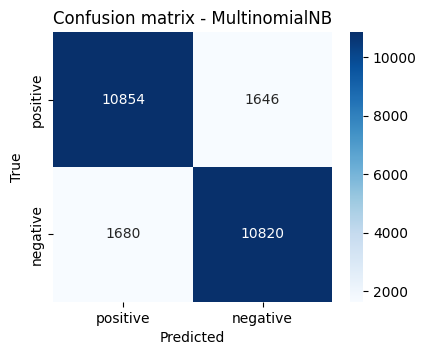


Modelo: LinearSVC
Accuracy: 0.8844
Macro - Precision: 0.8844  Recall: 0.8844  F1: 0.8844
Weighted - Precision: 0.8844  Recall: 0.8844  F1: 0.8844

Per-class (positive / negative):
 Precision: 0.8834 / 0.8855
 Recall:    0.8858 / 0.8831
 F1-score:  0.8846 / 0.8843

Classification report:

              precision    recall  f1-score   support

    positive       0.88      0.89      0.88     12500
    negative       0.89      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



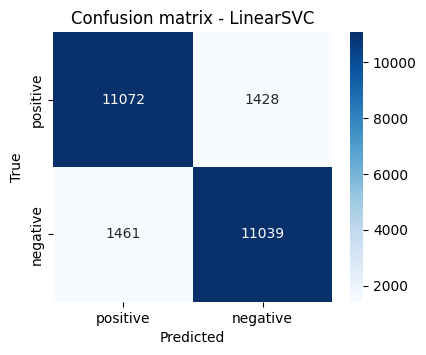

,accuracy,precision_macro,recall_macro,f1_macro,precision_weighted,recall_weighted,f1_weighted,pos_precision,pos_recall,pos_f1,neg_precision,neg_recall,neg_f1
model,,,,,,,,,,,,,
LogisticRegression,0.9011,0.9012,0.9011,0.9011,0.9012,0.9011,0.9011,0.8972,0.9061,0.9016,0.9051,0.8962,0.9006
MultinomialNB,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8670,0.8660,0.8683,0.8671,0.8680,0.8656,0.8668
LinearSVC,0.8844,0.8844,0.8844,0.8844,0.8844,0.8844,0.8844,0.8834,0.8858,0.8846,0.8855,0.8831,0.8843


In [40]:

# Asegúrate de que y_test y las predicciones existen
models_preds = {
    "LogisticRegression": y_pred_logreg,
    "MultinomialNB": y_pred_nb,
    "LinearSVC": y_pred_svm
}

summary_rows = []

def print_cm(y_true, y_pred, title):
    labels_order = ["positive", "negative"]  # ajusta si tus labels son otras
    cm = confusion_matrix(y_true, y_pred, labels=labels_order)
    plt.figure(figsize=(4.5,3.5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=labels_order, yticklabels=labels_order)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()

for name, y_pred in models_preds.items():
    # accuracy
    acc = accuracy_score(y_test, y_pred)
    # macro and weighted precision/recall/f1
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(y_test, y_pred, average="macro")
    prec_weight, rec_weight, f1_weight, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
    # per-class metrics (order: positive, negative)
    per_prec, per_rec, per_f1, support = precision_recall_fscore_support(y_test, y_pred, labels=["positive","negative"])
    pos_prec, neg_prec = per_prec[0], per_prec[1]
    pos_rec, neg_rec = per_rec[0], per_rec[1]
    pos_f1,  neg_f1  = per_f1[0], per_f1[1]

    # print human-friendly report
    print("\n" + "="*60)
    print(f"Modelo: {name}")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro - Precision: {prec_macro:.4f}  Recall: {rec_macro:.4f}  F1: {f1_macro:.4f}")
    print(f"Weighted - Precision: {prec_weight:.4f}  Recall: {rec_weight:.4f}  F1: {f1_weight:.4f}")
    print("\nPer-class (positive / negative):")
    print(f" Precision: {pos_prec:.4f} / {neg_prec:.4f}")
    print(f" Recall:    {pos_rec:.4f} / {neg_rec:.4f}")
    print(f" F1-score:  {pos_f1:.4f} / {neg_f1:.4f}")
    print("\nClassification report:\n")
    print(classification_report(y_test, y_pred, labels=["positive","negative"]))
    print("="*60)

    # add to summary table
    summary_rows.append({
        "model": name,
        "accuracy": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "precision_weighted": prec_weight,
        "recall_weighted": rec_weight,
        "f1_weighted": f1_weight,
        "pos_precision": pos_prec,
        "pos_recall": pos_rec,
        "pos_f1": pos_f1,
        "neg_precision": neg_prec,
        "neg_recall": neg_rec,
        "neg_f1": neg_f1
    })

    # show confusion matrix for this model
    print_cm(y_test, y_pred, f"Confusion matrix - {name}")

# show summary dataframe
summary_df = pd.DataFrame(summary_rows).set_index("model")
display(summary_df.round(4))


# Análisis de Error

In [43]:
# Escogemos un modelo para analizar (ej. Logistic Regression)
y_pred = y_pred_logreg  

# Encuentra índices de errores
errores_idx = [i for i, (y_true, y_hat) in enumerate(zip(y_test, y_pred)) if y_true != y_hat]

print("Total errores:", len(errores_idx))

# Muestra algunos ejemplos al azar usando el texto original
for i in random.sample(errores_idx, 5):
    print("="*80)
    print("🔹 Review original:")
    print(test_df.iloc[i]["review"])   # aquí usamos test_df, no X_test
    print("✅ Sentiment real:", test_df.iloc[i]["sentiment"])
    print("❌ Predicción modelo:", y_pred[i])

Total errores: 2472
🔹 Review original:
Charles Bronson stars as Lt Crowe a police detective who declares war on a pimp named Duke (Juan Fernandez) who kidnaps the daughter of a Japanese businessman who is the man who sexually harassed Crowe's daughter (Amy Hathaway) in this sleazy yet stylishly helmed revenge thriller. Kinjite may not be for everyone with it's somewhat disturbing plot threads but it is well made and indeed entertaining.
✅ Sentiment real: negative
❌ Predicción modelo: positive
🔹 Review original:
Even though this film's trailer and poster imply that Sally Hemmings was an important character, I might not have been as shocked to discover she was just a minor (and I do mean Minor) character if this movie was suppose to being told by Sally's very own family! I mean if you are going to tell the story of a member of your family that has been ignored by history, would you really tell it with the man who relegated her to obscurity at the main character? His other lover (who happ